# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras import regularizers

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
# Extract data and labels
train_images, train_labels = train['X'], train['y']
test_images, test_labels = test['X'], test['y']
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

In [4]:
# Convert the 10th label to 0th label, for using sparse categorical crossentropy
train_labels[:,0][train_labels[:,0]==10]= 0
test_labels[:,0][test_labels[:,0]==10]= 0

In [5]:
# Plot random samples from train/test dataset
def visualize_data(images, labels, mode = 'color'):
    """
    Plots 16 random samples of the train/test data
    """
    # Take 16 random samples
    random_idx = random.sample(range(images.shape[-1]), 16)
    fig = plt.figure(figsize=(10, 10))
    for i in range(16):
        idx = random_idx[i]
        plt.subplot(4, 4, i+1)
        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
        # Plot the images
        if mode!='color':
            plt.imshow(images[..., idx], cmap = 'gray')
        else:
            plt.imshow(images[..., idx])
        # Title is kept as the digit label
        plt.title('Digit: {}'.format(labels[idx][0])) 
    plt.show()

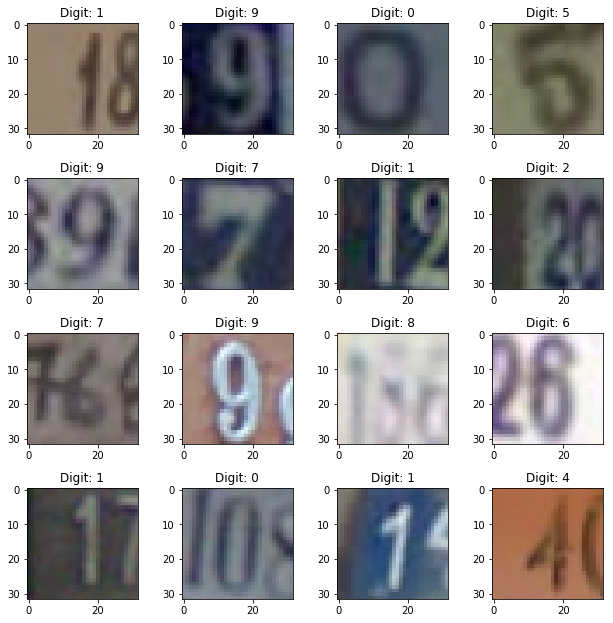

In [6]:
visualize_data(train_images, train_labels, mode = 'color')

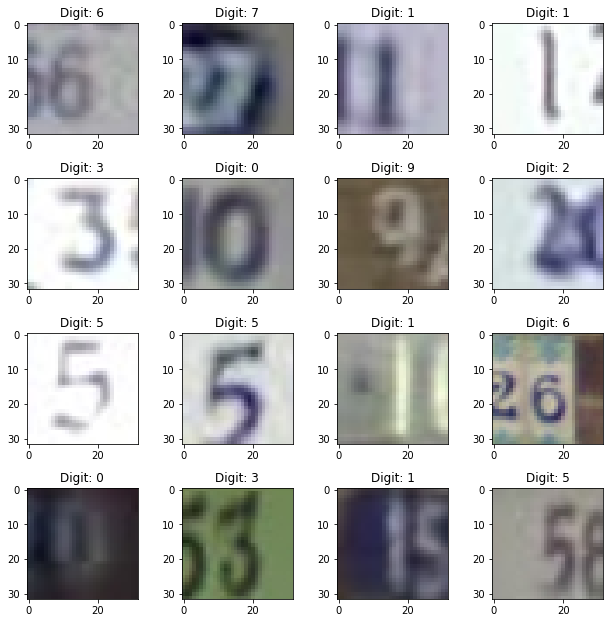

In [7]:
visualize_data(test_images, test_labels, mode = 'color')

In [8]:
## Averaging across all channels
train_images = np.mean(train_images, axis = 2)
test_images = np.mean(test_images, axis = 2)

In [9]:
# Compute overall mean and standard deviation images of the dataset
mean_img = np.mean(np.concatenate([train_images, test_images], axis = 2), axis = 2)
stddev_img = np.std(np.concatenate([train_images, test_images], axis = 2), axis = 2)
train_images_norm = (train_images - mean_img[:,:,np.newaxis])/stddev_img[:,:,np.newaxis]
test_images_norm = (test_images - mean_img[:,:,np.newaxis])/stddev_img[:,:,np.newaxis]

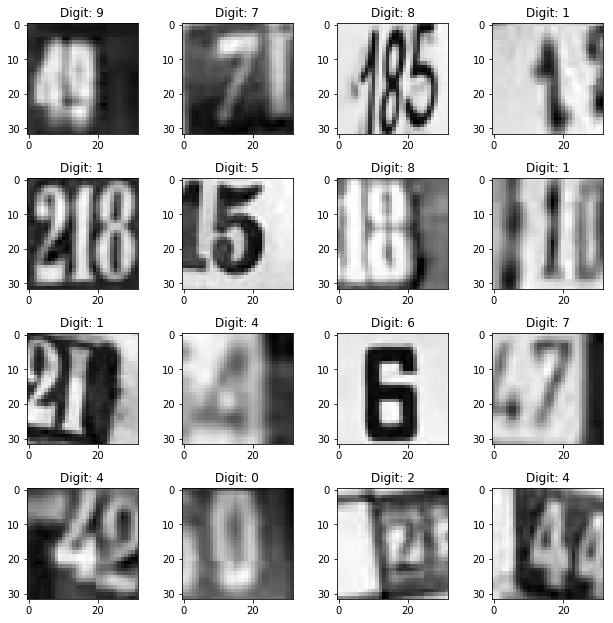

In [10]:
# Visualize After Averaging Channels
visualize_data(train_images, train_labels, mode = 'gray')

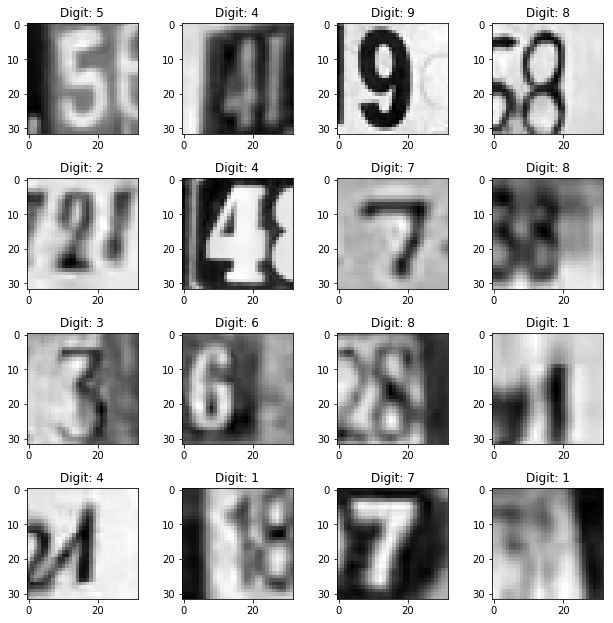

In [11]:
## Visualize Normalized Images after converting to Grayscale
visualize_data(train_images_norm, train_labels, mode = 'gray')

In [12]:
# Reshape such that the output dimension is (batch_size, num_features, num_features, 1) for input to Dense layer
train_images_norm = train_images_norm.transpose(2, 0, 1).reshape(-1, 32, 32, 1)
test_images_norm = test_images_norm.transpose(2, 0, 1).reshape(-1, 32, 32, 1)

In [13]:
# Split the dataset with validation split = 0.15, using stratify = train_labels will make the split balanced (reduce overfit)
X_train, X_val, y_train, y_val = train_test_split(train_images_norm, train_labels, test_size = 0.15, stratify = train_labels)
X_test, y_test = test_images_norm, test_labels

In [14]:
# Delete unnecessary data which wont be used further
del train, test, train_images, test_images, train_images_norm, test_images_norm

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [15]:
# Define MLP Model
model = Sequential([Flatten(input_shape = (32, 32, 1), name = 'flatten'),
                    Dense(512, activation = 'relu', name = 'dense_1'),
                    Dense(128, activation= 'relu', name = 'dense_2'),
                    Dense(64, activation = 'relu', name = 'dense_3'),
                    Dense(32, activation = 'relu', name = 'dense_4'),
                    Dense(10, activation = 'softmax', name = 'output')])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 601,130
Trainable params: 601,130
Non-trainable params: 0
__________________________________________________

In [16]:
## Callbacks for MLP model

# Early stopping callback with a patience of 10, monitors val_loss
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min')

# Saves only the best model according to val_loss
model_checkpoint_callback = ModelCheckpoint(filepath = 'checkpoint/model_{epoch:02d}', save_weights_only = True,
                                            save_best_only = True, save_freq = 'epoch', 
                                            monitor = 'val_loss', mode = 'min', verbose = 1)

# CSVLogger saves the results as a csv file
csvlogger_checkpoint = CSVLogger('results.csv')

In [17]:
# Compile and Fit the model, store the history of MLP later for getting checkpoint
model.compile(optmizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size = 64,
                    epochs = 20, callbacks = [early_stopping_callback, model_checkpoint_callback, csvlogger_checkpoint],
                    validation_data = (X_val, y_val), verbose = 1)

Train on 62268 samples, validate on 10989 samples
Epoch 1/20
62208/62268 [============================>.] - ETA: 0s - loss: 1.3830 - accuracy: 0.5491
Epoch 00001: val_loss improved from inf to 1.00603, saving model to checkpoint/model_01
62268/62268 [==============================] - 71s 1ms/sample - loss: 1.3826 - accuracy: 0.5492 - val_loss: 1.0060 - val_accuracy: 0.6779
Epoch 2/20
62144/62268 [============================>.] - ETA: 0s - loss: 0.9478 - accuracy: 0.7054
Epoch 00002: val_loss improved from 1.00603 to 0.86031, saving model to checkpoint/model_02
62268/62268 [==============================] - 54s 869us/sample - loss: 0.9478 - accuracy: 0.7055 - val_loss: 0.8603 - val_accuracy: 0.7299
Epoch 3/20
62144/62268 [============================>.] - ETA: 0s - loss: 0.8279 - accuracy: 0.7458
Epoch 00003: val_loss did not improve from 0.86031
62268/62268 [==============================] - 54s 875us/sample - loss: 0.8281 - accuracy: 0.7458 - val_loss: 0.8809 - val_accuracy: 0.7249
E

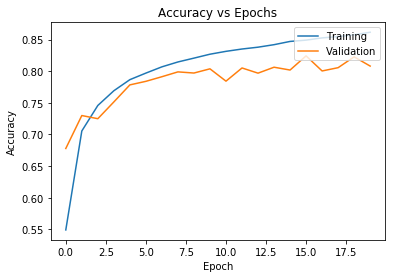

In [18]:
# Plot Train and Validation Accuracy for MLP Model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

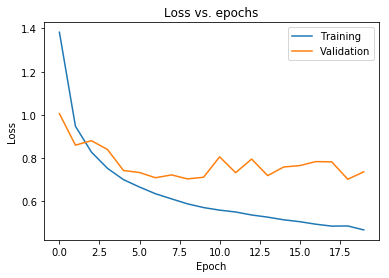

In [19]:
# Plot Train and Validation Loss for MLP Model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [20]:
# Evaluate MLP Model on Test Data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)
print("Test loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

Test loss: 0.924770849060265, Test Accuracy: 0.7801551818847656


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [21]:
# Instantiate CNN Model
cnn_model = Sequential([
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same',
           input_shape = (32, 32, 1), name = 'conv_1'),
    MaxPooling2D((3, 3), name = 'pool_1'),
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same',
           name = 'conv_2'),
    MaxPooling2D((3, 3), name = 'pool_2'),
    Flatten(name = 'flatten'),
    Dense(units = 128, activation = 'relu', name = 'dense_1'),
    Dense(units = 64, activation = 'relu', name = 'dense_2'),
    Dense(units = 10, activation = 'softmax', name = 'dense_3')
])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 10, 10, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 10, 10, 64)        36928     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               73856     
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [22]:
# Callbacks for CNN Model
cnn_early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')
cnn_model_checkpoint_callback = ModelCheckpoint(filepath = 'cnn_model_checkpoint/model_{epoch:02d}', save_weights_only = True, 
                                            save_freq = 'epoch', save_best_only = True,
                                            monitor = 'val_loss', mode = 'min', verbose = 1)

In [23]:
# Compile and Fit the CNN Model, store history for accessing checkpoints later
cnn_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train, batch_size = 64,
                    epochs = 20, callbacks = [cnn_early_stopping_callback, cnn_model_checkpoint_callback],
                    validation_data = (X_val, y_val), verbose = 1)

Train on 62268 samples, validate on 10989 samples
Epoch 1/20
62208/62268 [============================>.] - ETA: 0s - loss: 0.9327 - accuracy: 0.7026
Epoch 00001: val_loss improved from inf to 0.57043, saving model to cnn_model_checkpoint/model_01
62268/62268 [==============================] - 402s 6ms/sample - loss: 0.9324 - accuracy: 0.7028 - val_loss: 0.5704 - val_accuracy: 0.8344
Epoch 2/20
62208/62268 [============================>.] - ETA: 0s - loss: 0.5176 - accuracy: 0.8465
Epoch 00002: val_loss improved from 0.57043 to 0.47909, saving model to cnn_model_checkpoint/model_02
62268/62268 [==============================] - 393s 6ms/sample - loss: 0.5179 - accuracy: 0.8464 - val_loss: 0.4791 - val_accuracy: 0.8575
Epoch 3/20
62208/62268 [============================>.] - ETA: 0s - loss: 0.4344 - accuracy: 0.8683
Epoch 00003: val_loss improved from 0.47909 to 0.40881, saving model to cnn_model_checkpoint/model_03
62268/62268 [==============================] - 393s 6ms/sample - loss:

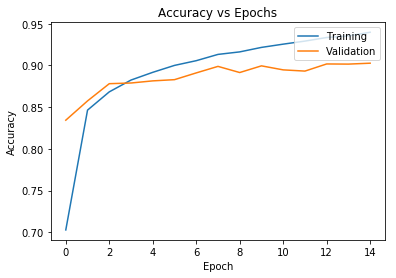

In [24]:
# Plot Train and Validation Accuracy for CNN Model
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

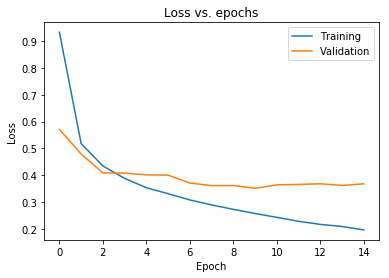

In [25]:
# Plot Train and Validation Loss for CNN Model
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [26]:
# Test Loss of CNN Model
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose = 2)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

26032/1 - 47s - loss: 0.3610 - accuracy: 0.8978
Test Loss: 0.39057045084376807, Test Accuracy: 0.897779643535614


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [27]:
# Use the history of MLP and CNN Models to get a dataframe
df_mlp = pd.DataFrame(history.history)
df_cnn = pd.DataFrame(cnn_history.history)

In [28]:
# Since we saved the best model (each epoch) only when the val_loss was min, we extract the epoch
mlp_best_epoch = df_mlp.val_loss.idxmin() + 1
cnn_best_epoch = df_cnn.val_loss.idxmin() + 1

In [29]:
# We use the epoch at which val_loss was minimum to get the model checkpoint path
mlp_best_checkpoint = '/home/jovyan/work/5/checkpoint/model_{}'.format(mlp_best_epoch)
cnn_best_checkpoint = '/home/jovyan/work/5/cnn_model_checkpoint/model_{}'.format(cnn_best_epoch)

In [30]:
## Instantiate new models MLP and CNN to load the weights
mlp_model = Sequential([Flatten(input_shape = (32, 32, 1), name = 'flatten'),
                    Dense(512, activation = 'relu', name = 'dense_1'),
                    Dense(128, activation= 'relu', name = 'dense_2'),
                    Dense(64, activation = 'relu', name = 'dense_3'),
                    Dense(32, activation = 'relu', name = 'dense_4'),
                    Dense(10, activation = 'softmax', name = 'output')])
cnn_model = Sequential([
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same',
           input_shape = (32, 32, 1), name = 'conv_1'),
    MaxPooling2D((3, 3), name = 'pool_1'),
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same',
           name = 'conv_2'),
    MaxPooling2D((3, 3), name = 'pool_2'),
    Flatten(name = 'flatten'),
    Dense(units = 128, activation = 'relu', name = 'dense_1'),
    Dense(units = 64, activation = 'relu', name = 'dense_2'),
    Dense(units = 10, activation = 'softmax', name = 'dense_3')
])

In [31]:
## Load weights using checkpoint and new model
mlp_model.load_weights(mlp_best_checkpoint)
cnn_model.load_weights(cnn_best_checkpoint)

In [32]:
## Predict on test data
mlp_predictions = mlp_model.predict(X_test)
cnn_predictions = cnn_model.predict(X_test)

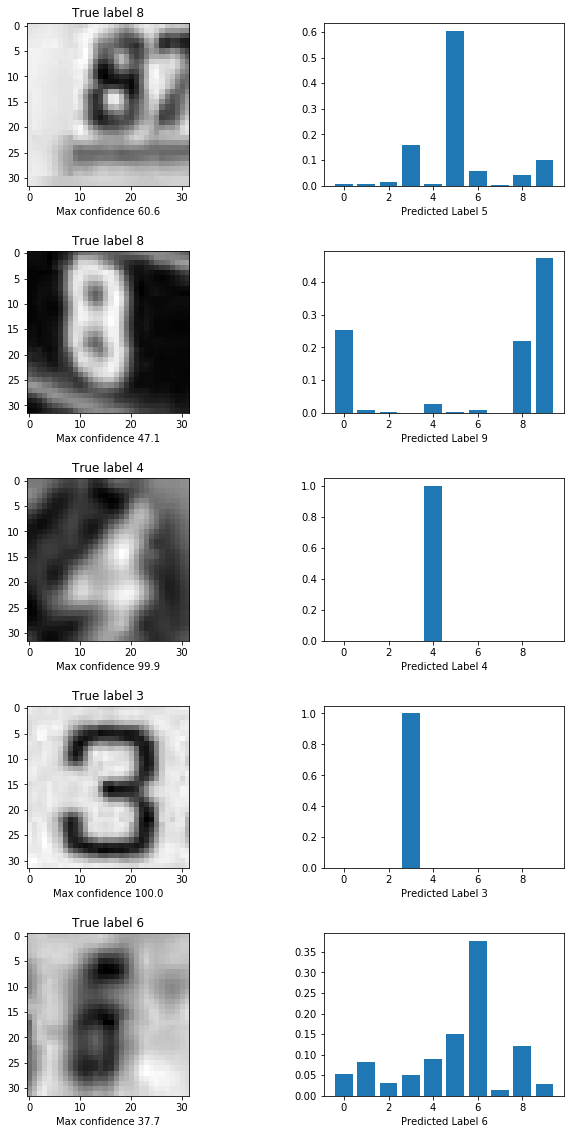

In [44]:
# Plot the predictions for MLP
#random_idx = random.sample(range(X_test.shape[0]), 5)
fig = plt.figure(figsize=(10, 10))
for i in range(5):
    idx = random_idx[i]
    predicted_label = np.argmax(mlp_predictions[idx])
    confidence = np.round(mlp_predictions[idx].max()*100, 1)
    true_label = y_test[idx][0]
    plt.subplot(5, 2, 2*i+1)
    plt.subplots_adjust(left=0.1,
                        bottom=0.01, 
                        top=1.5, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.imshow(X_test[idx].reshape(32, 32), cmap = 'gray')
    plt.title('True label {}'.format(true_label))
    plt.xlabel('Max confidence {}'.format(confidence))
    plt.subplot(5, 2, 2*i+2)
    plt.bar(range(10), mlp_predictions[idx])
    plt.xlabel('Predicted Label {}'.format(predicted_label))
plt.show()

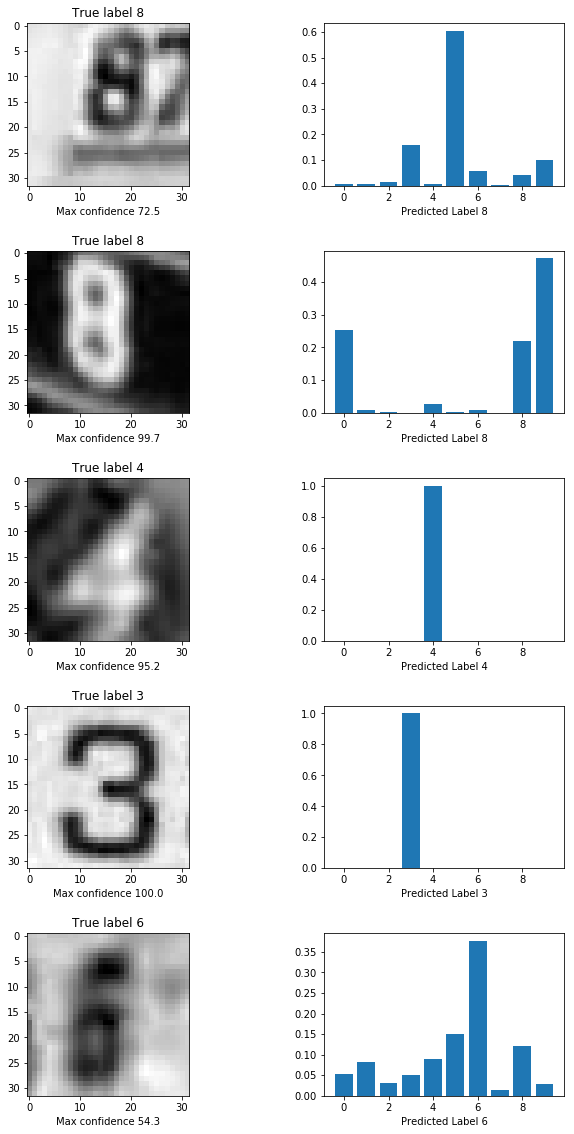

In [45]:
# Plot the predictions for CNN
fig = plt.figure(figsize=(10, 10))
for i in range(5):
    idx = random_idx[i]
    predicted_label = np.argmax(cnn_predictions[idx])
    confidence = np.round(cnn_predictions[idx].max()*100, 1)
    true_label = y_test[idx][0]
    plt.subplot(5, 2, 2*i+1)
    plt.subplots_adjust(left=0.1,
                        bottom=0.01, 
                        top=1.5, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.imshow(X_test[idx].reshape(32, 32), cmap = 'gray')
    plt.title('True label {}'.format(true_label))
    plt.xlabel('Max confidence {}'.format(confidence))
    plt.subplot(5, 2, 2*i+2)
    plt.bar(range(10), mlp_predictions[idx])
    plt.xlabel('Predicted Label {}'.format(predicted_label))
plt.show()